In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name(), font)

Microsoft PhagsPa C:\Windows\Fonts\phagspa.ttf
Stencil C:\Windows\Fonts\STENCIL.TTF
Times New Roman C:\Windows\Fonts\timesbi.ttf
Rockwell C:\Windows\Fonts\ROCK.TTF
New Gulim C:\Windows\Fonts\NGULIM.TTF
Georgia C:\Windows\Fonts\georgiab.ttf
Arial Rounded MT Bold C:\Windows\Fonts\ARLRDBD.TTF
Eras Bold ITC C:\Windows\Fonts\ERASBD.TTF
Corbel C:\Windows\Fonts\corbeli.ttf
Hancom MalangMalang C:\Windows\Fonts\MalangmalangR.ttf
Courier New C:\Windows\Fonts\courbi.ttf
Lucida Sans C:\Windows\Fonts\LSANSDI.TTF
Franklin Gothic Medium C:\Windows\Fonts\framd.ttf
Tw Cen MT C:\Windows\Fonts\TCMI____.TTF
LG Smart UI C:\Windows\Fonts\LG_Smart_UI-Bold.ttf
Microsoft Tai Le C:\Windows\Fonts\taileb.ttf
Eras Medium ITC C:\Windows\Fonts\ERASMD.TTF
Lucida Bright C:\Windows\Fonts\LBRITEI.TTF
Rockwell Condensed C:\Windows\Fonts\ROCC____.TTF
Franklin Gothic Demi Cond C:\Windows\Fonts\FRADMCN.TTF
Microsoft New Tai Lue C:\Windows\Fonts\ntailub.ttf
Gill Sans MT C:\Windows\Fonts\GIL_____.TTF
Calisto MT C:\Windows\Fon

In [2]:
import pandas as pd
import numpy as np

# !pip install pykrx
from pykrx import stock

from tqdm import tqdm
import time

import seaborn as sns

In [3]:
df = pd.read_csv("./meta_data.csv")
df

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,120110,코오롱인더,KOSPI,화학,36550,-50,-0.14,1005822776050
1,150,두산,KOSPI,기타금융,137000,4100,3.09,2263765395000
2,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
3,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
4,4560,현대비앤지스틸,KOSPI,철강금속,20950,600,2.95,315901090450
...,...,...,...,...,...,...,...,...
141,4990,롯데지주,KOSPI,기타금융,26500,-300,-1.12,2780094780500
142,267260,HD현대일렉트릭,KOSPI,전기전자,255000,15000,6.25,9192019425000
143,1740,SK네트웍스,KOSPI,유통업,5540,-20,-0.36,1225879577080
144,5930,삼성전자,KOSPI,전기전자,78600,3100,4.11,469224908430000


In [4]:
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)

In [5]:
import numpy as np 
from statsmodels import regression
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import math
import pandas as pd 
import pandas_datareader as pdr 

In [6]:
sector_counts = df.groupby('업종명').size().reset_index(name='종목수')

print(sector_counts)

      업종명  종목수
0     건설업    6
1      기계    3
2    기타금융   20
3      보험    4
4   비금속광물    4
5    서비스업   11
6    섬유의복    1
7    운수장비   10
8   운수창고업    6
9     유통업   13
10     은행    2
11   음식료품    3
12    의약품    7
13  전기가스업    3
14   전기전자   13
15   종이목재    2
16     증권    5
17   철강금속    7
18    통신업    2
19     화학   24


In [7]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import networkx as nx

In [8]:
def create_graph_with_correlation(df, start, end):
    G = nx.Graph()
    
    # 모든 주식의 종가 데이터 가져오기
    stock_prices = {}
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        try:
            asset = fdr.DataReader(code, start, end)
            stock_prices[code] = asset['Close']
        except:
            print(f"No data for {code} ({name})")
            continue
    
    # 가장 긴 공통 기간 찾기
    min_date = max([prices.index.min() for prices in stock_prices.values() if not prices.empty])
    max_date = min([prices.index.max() for prices in stock_prices.values() if not prices.empty])
    
    # 유효한 기간이 없는 경우 처리
    if pd.isna(min_date) or pd.isna(max_date):
        raise ValueError("No common dates available in the dataset.")
    
    # 공통 기간 내의 데이터를 기준으로 필터링
    common_dates = pd.date_range(start=min_date, end=max_date)
    print(f"Common date range: {min_date} to {max_date}")

    filtered_prices = {}
    for code in stock_prices:
        filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
    # 시가총액 상위 50개 종목 선택
    valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]
    top_50_df = df[df['종목코드'].isin(valid_codes)].nlargest(100, '시가총액')

    print(f"Valid codes after filtering: {len(valid_codes)}")
    print(f"Top 50 codes selected: {len(top_50_df)}")

    # 시가총액 상위 50개 종목에 대해 다시 종가 데이터를 가져오기
    stock_prices_top_50 = {code: filtered_prices[code] for code in top_50_df['종목코드']}

    for idx, row in tqdm(top_50_df.iterrows(), total=top_50_df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        
        # 그래프 노드에 종목명과 업종명 추가
        G.add_node(name, sector=sector)
    
    codes = list(stock_prices_top_50.keys())
    edges = []

    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            code_i = codes[i]
            code_j = codes[j]
            
            # 두 종목의 종가 데이터 가져오기
            prices_i = stock_prices_top_50[code_i]
            prices_j = stock_prices_top_50[code_j]
            
            # 상관 관계 계산
            if len(prices_i) > 1 and len(prices_j) > 1:
                correlation = prices_i.corr(prices_j)
                if not np.isnan(correlation):
                    weight = np.sqrt(2 * (1 - correlation))
                    edges.append((df.loc[df['종목코드'] == code_i, '종목명'].values[0],
                                  df.loc[df['종목코드'] == code_j, '종목명'].values[0],
                                  weight))

    # edge weight 기준 하위 10% 선택
    edges = sorted(edges, key=lambda x: x[2])
    num_edges_to_keep = int(len(edges) * 0.1)
    edges_to_add = edges[:num_edges_to_keep]

    # 그래프에 엣지 추가
    for edge in edges_to_add:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    # 연결된 엣지가 없는 노드 제거
    nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
    G.remove_nodes_from(nodes_to_remove)
    print(f"Nodes removed due to no edges: {len(nodes_to_remove)}")

    return G

In [9]:
# def create_graph_with_correlation(df, start, end):
#     G = nx.Graph()
    
#     # 모든 주식의 종가 데이터 가져오기
#     stock_prices = {}
#     for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         code = row["종목코드"]
#         name = row["종목명"]
#         sector = row["업종명"]
#         try:
#             asset = fdr.DataReader(code, start, end)
#             stock_prices[code] = asset['Close']
#         except:
#             print(f"No data for {code} ({name})")
#             continue
    
#     # 가장 긴 공통 기간 찾기
#     min_date = max([prices.index.min() for prices in stock_prices.values() if not prices.empty])
#     max_date = min([prices.index.max() for prices in stock_prices.values() if not prices.empty])
    
#     # 유효한 기간이 없는 경우 처리
#     if pd.isna(min_date) or pd.isna(max_date):
#         raise ValueError("No common dates available in the dataset.")
    
#     # 공통 기간 내의 데이터를 기준으로 필터링
#     common_dates = pd.date_range(start=min_date, end=max_date)
#     print(f"Common date range: {min_date} to {max_date}")

#     filtered_prices = {}
#     for code in stock_prices:
#         filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
#     # 유효한 종목 코드 필터링
#     valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]

#     print(f"Valid codes after filtering: {len(valid_codes)}")

#     # 유효한 종목 코드에 대해 다시 종가 데이터를 가져오기
#     stock_prices_valid = {code: filtered_prices[code] for code in valid_codes}

#     for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
#         code = row["종목코드"]
#         if code in valid_codes:
#             name = row["종목명"]
#             sector = row["업종명"]
        
#             # 그래프 노드에 종목명과 업종명 추가
#             G.add_node(name, sector=sector)
    
#     codes = list(stock_prices_valid.keys())
#     edges = []

#     for i in range(len(codes)):
#         for j in range(i + 1, len(codes)):
#             code_i = codes[i]
#             code_j = codes[j]
            
#             # 두 종목의 종가 데이터 가져오기
#             prices_i = stock_prices_valid[code_i]
#             prices_j = stock_prices_valid[code_j]
            
#             # 상관 관계 계산
#             if len(prices_i) > 1 and len(prices_j) > 1:
#                 correlation = prices_i.corr(prices_j)
#                 if not np.isnan(correlation):
#                     weight = np.sqrt(2 * (1 - correlation))
#                     edges.append((df.loc[df['종목코드'] == code_i, '종목명'].values[0],
#                                   df.loc[df['종목코드'] == code_j, '종목명'].values[0],
#                                   weight))

#     # edge weight 기준 하위 10% 선택
#     edges = sorted(edges, key=lambda x: x[2])
#     num_edges_to_keep = int(len(edges) * 0.1)
#     edges_to_add = edges[:num_edges_to_keep]

#     # 그래프에 엣지 추가
#     for edge in edges_to_add:
#         G.add_edge(edge[0], edge[1], weight=edge[2])

#     # 연결된 엣지가 없는 노드 제거
#     nodes_to_remove = [node for node in G.nodes if G.degree(node) == 0]
#     G.remove_nodes_from(nodes_to_remove)
#     print(f"Nodes removed due to no edges: {len(nodes_to_remove)}")

#     return G


In [10]:
start_date = '2010-01-01'
end_date = '2019-12-31'

G = create_graph_with_correlation(df, start_date, end_date)

num_nodes = G.number_of_nodes()

print(f"Number of nodes in the graph: {num_nodes}")


100%|██████████| 146/146 [00:25<00:00,  5.73it/s]


Common date range: 2019-11-19 00:00:00 to 2019-12-30 00:00:00
Valid codes after filtering: 129
Top 50 codes selected: 100


100%|██████████| 100/100 [00:00<?, ?it/s]


Nodes removed due to no edges: 16
Number of nodes in the graph: 77


In [11]:
print("Edge weights:")
for (u, v, weight) in G.edges(data=True):
    print(f"({u}, {v}): {weight['weight']}")

Edge weights:
(삼성전자, HD현대건설기계): 0.32893530847205177
(삼성전자, 효성첨단소재): 0.3774378487055048
(삼성전자, 대한항공): 0.3856185872901054
(삼성전자, 고려아연): 0.4116531848513903
(삼성전자, 팬오션): 0.4341876262726118
(삼성전자, 삼성생명): 0.43903215252473693
(삼성전자, 유한양행): 0.4554824573755159
(삼성전자, JB금융지주): 0.4812964187949621
(삼성전자, S-Oil): 0.4888518907174615
(삼성전자, DB하이텍): 0.4942172284526628
(삼성전자, LG전자): 0.4981008708368439
(삼성전자, 롯데지주): 0.5112845724714259
(삼성전자, 하나금융지주): 0.5126367501920855
(삼성전자, NH투자증권): 0.5229070976782241
(삼성전자, 삼성증권): 0.5312161513978402
(삼성전자, 현대모비스): 0.5338584579380684
(삼성전자, LG유플러스): 0.5746893532812175
(삼성전자, 롯데케미칼): 0.5770226519681032
(삼성전자, BNK금융지주): 0.5787727676116045
(삼성전자, 한온시스템): 0.5791528394779925
(삼성전자, 한화솔루션): 0.5932684321841271
(삼성전자, 한전KPS): 0.6003063856534591
(삼성전자, LG): 0.6069538243789322
(삼성전자, 롯데쇼핑): 0.6104490075664856
(삼성전자, NAVER): 0.6129408963268147
(삼성전자, DGB금융지주): 0.6162851806465421
(삼성전자, HD현대일렉트릭): 0.634200247853249
(삼성전자, SK네트웍스): 0.6379573375031552
(삼성전자, 삼성중공업): 0.6648867051480

In [12]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

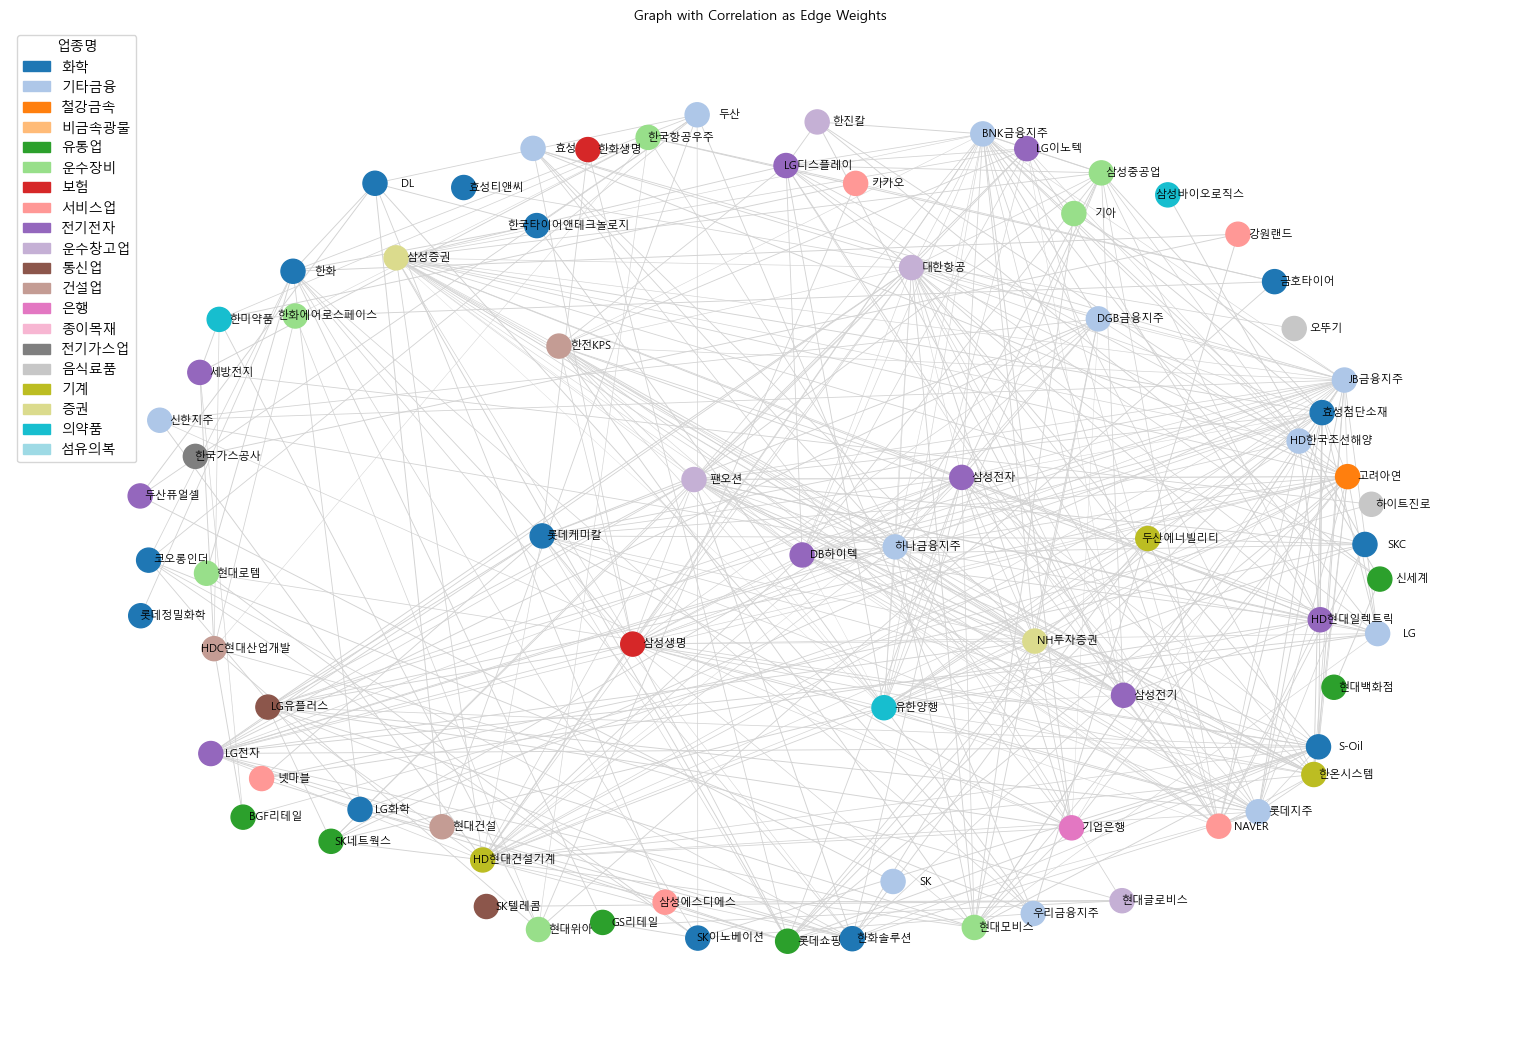

In [13]:
sectors = pd.unique(df["업종명"])
color_map = plt.get_cmap('tab20', len(sectors))
sector_color = {sector: color_map(i) for i, sector in enumerate(sectors)}

node_colors = [sector_color[G.nodes[node]['sector']] for node in G.nodes]

legend_patches = [mpatches.Patch(color=sector_color[sector], label=sector) for sector in sectors]

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=2)  # k 값을 조정하여 노드 간 거리 조정
weights = nx.get_edge_attributes(G, 'weight').values()

# 라벨 위치 조정
labels = {node: node for node in G.nodes}
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='lightgray', width=list(weights))
for p in pos:  # 라벨을 노드 옆에 배치
    pos[p][0] += 0.05
nx.draw_networkx_labels(G, pos, labels, font_family=font_prop.get_name(), font_size=8)

plt.title('Graph with Correlation as Edge Weights', fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# MST

In [14]:
mst = nx.minimum_spanning_tree(G)

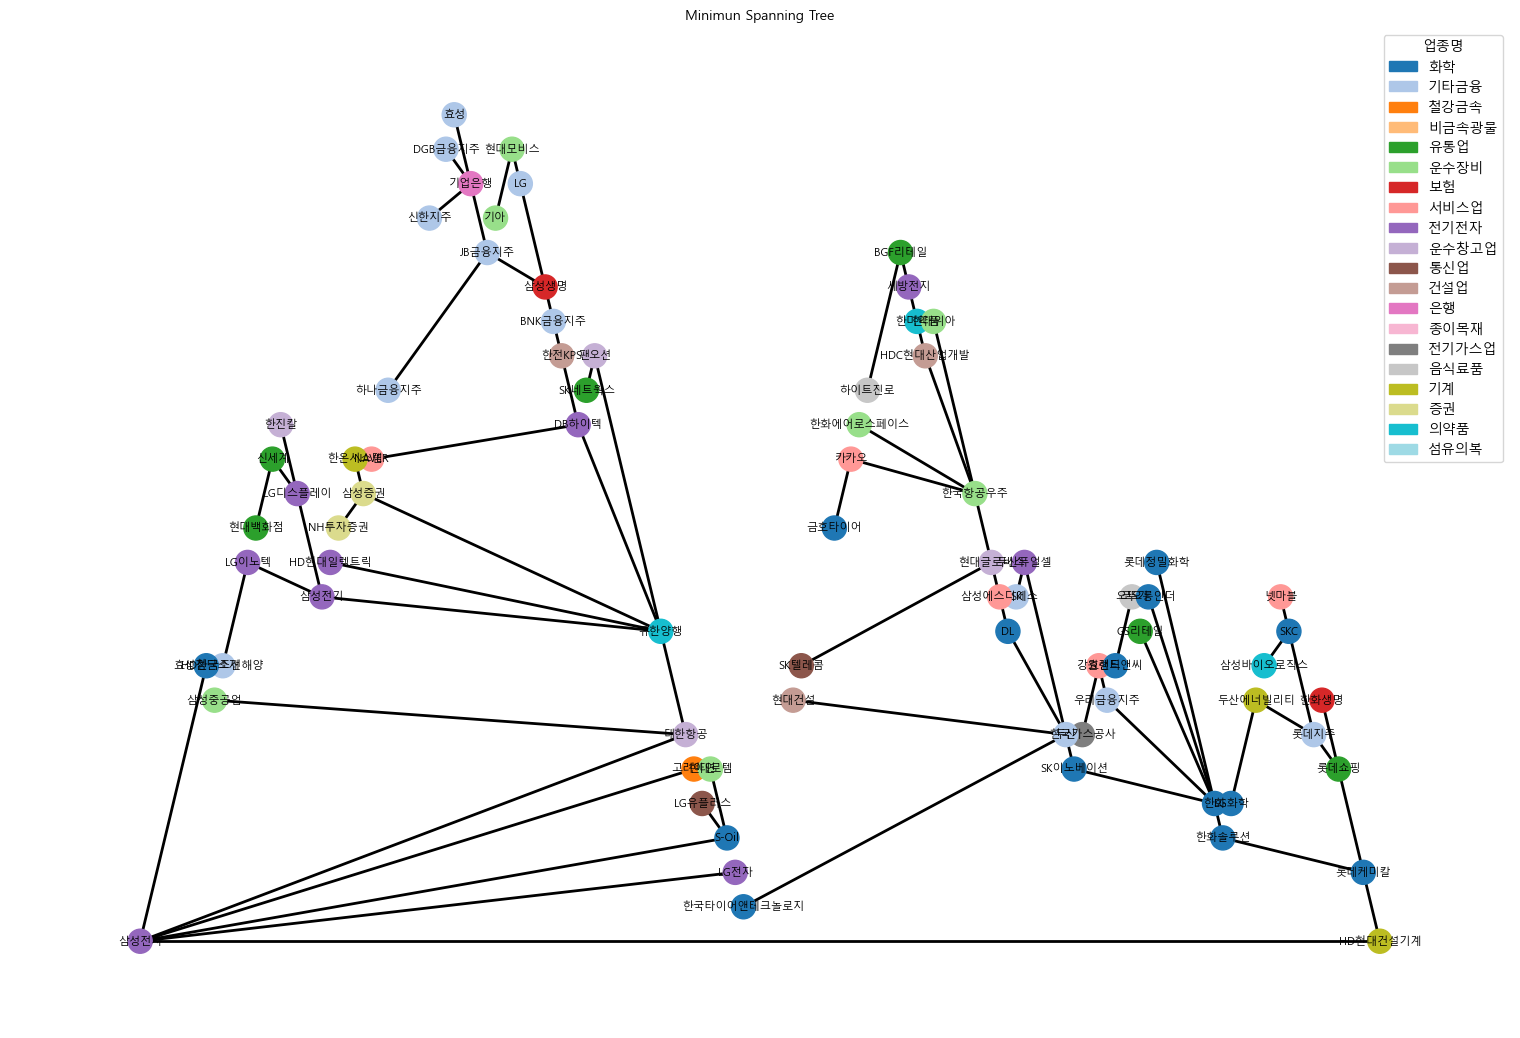

In [15]:
plt.figure(figsize=(15, 10))  
pos = nx.planar_layout(mst)  # 엣지 교차를 줄이기 위해 planar_layout 사용

nx.draw(mst, pos, with_labels=False, node_color=node_colors, edge_color='black', width=2, node_size=300)
nx.draw_networkx_labels(mst, pos, labels={node: node for node in mst.nodes()}, font_family=font_prop.get_name(), font_size=8)
plt.title("Minimun Spanning Tree", fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

In [16]:
def analyze_graph(G):
    # 평균 거리 (전체 노드 간 최단 경로의 평균)
    avg_distance = nx.average_shortest_path_length(G)
    
    # 최대 거리 (지름)
    diameter = nx.diameter(G)
    
    # Branch count
    branch_count = sum(1 for node in G.nodes if G.degree(node) > 2)
    
    # 분석 결과 반환
    return {
        "Average Distance": avg_distance,
        "Diameter": diameter,
        "Branch Count": branch_count
    }

In [17]:
components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)
mst = nx.minimum_spanning_tree(subgraph)

# Analyze the larger MST
analysis_results = analyze_graph(mst)

print(analysis_results)

{'Average Distance': 8.838198198198198, 'Diameter': 24, 'Branch Count': 19}


# Centrality Analysis

In [18]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [19]:
centrality_df = pd.DataFrame({
    '종목코드': list(G.nodes),
    '업종명': [G.nodes[node]['sector'] for node in G.nodes],
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
})

In [20]:
for centrality in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']:
    print(f"Top 5 {centrality}")
    display(centrality_df[['종목코드', '업종명', centrality]].nlargest(5, centrality))
    print("\n")

Top 5 Degree Centrality


,종목코드,업종명,Degree Centrality
0,삼성전자,전기전자,0.394737
53,팬오션,운수창고업,0.381579
26,대한항공,운수창고업,0.368421
48,JB금융지주,기타금융,0.368421
8,삼성생명,보험,0.342105




Top 5 Betweenness Centrality


,종목코드,업종명,Betweenness Centrality
55,한화,화학,0.384534
75,DL,화학,0.296990
14,삼성에스디에스,서비스업,0.261053
28,현대글로비스,운수창고업,0.246667
36,롯데케미칼,화학,0.229419




Top 5 Closeness Centrality


,종목코드,업종명,Closeness Centrality
36,롯데케미칼,화학,0.385308
38,한화솔루션,화학,0.375274
0,삼성전자,전기전자,0.369501
53,팬오션,운수창고업,0.369501
48,JB금융지주,기타금융,0.362074




Top 5 Eigenvector Centrality


,종목코드,업종명,Eigenvector Centrality
0,삼성전자,전기전자,0.246092
53,팬오션,운수창고업,0.236928
26,대한항공,운수창고업,0.233724
8,삼성생명,보험,0.223064
48,JB금융지주,기타금융,0.222852


# Influence Maximization

In [21]:
import random

# 독립적 연접 모델을 사용한 영향 평가 함수
def independent_cascade(G, seed_nodes, steps=1000):
    influenced_nodes = set(seed_nodes)
    new_active = set(seed_nodes)
    for _ in range(steps):
        if not new_active:
            break
        next_active = set()
        for node in new_active:
            for neighbor in G.neighbors(node):
                if neighbor not in influenced_nodes and random.random() < G[node][neighbor]['weight']:
                    next_active.add(neighbor)
        influenced_nodes.update(next_active)
        new_active = next_active
    return len(influenced_nodes)

In [22]:
# Greedy Algorithm을 사용한 시드 노드 선택
def greedy_algorithm(G, k, steps=1000):
    seed_nodes = []
    for _ in tqdm(range(k)):
        best_node = None
        max_influence = -1
        for node in tqdm(G.nodes):
            if node not in seed_nodes:
                influence = independent_cascade(G, seed_nodes + [node], steps)
                if influence > max_influence:
                    best_node = node
                    max_influence = influence
        seed_nodes.append(best_node)
    return seed_nodes

In [23]:
# 시드 노드 수 설정
k = 1

# Greedy Algorithm을 사용하여 시드 노드 선택
seed_nodes = greedy_algorithm(G, k)
print(f"Selected seed nodes: {seed_nodes}")

100%|██████████| 1/1 [00:00<00:00, 40.95it/s]

Selected seed nodes: ['현대건설']


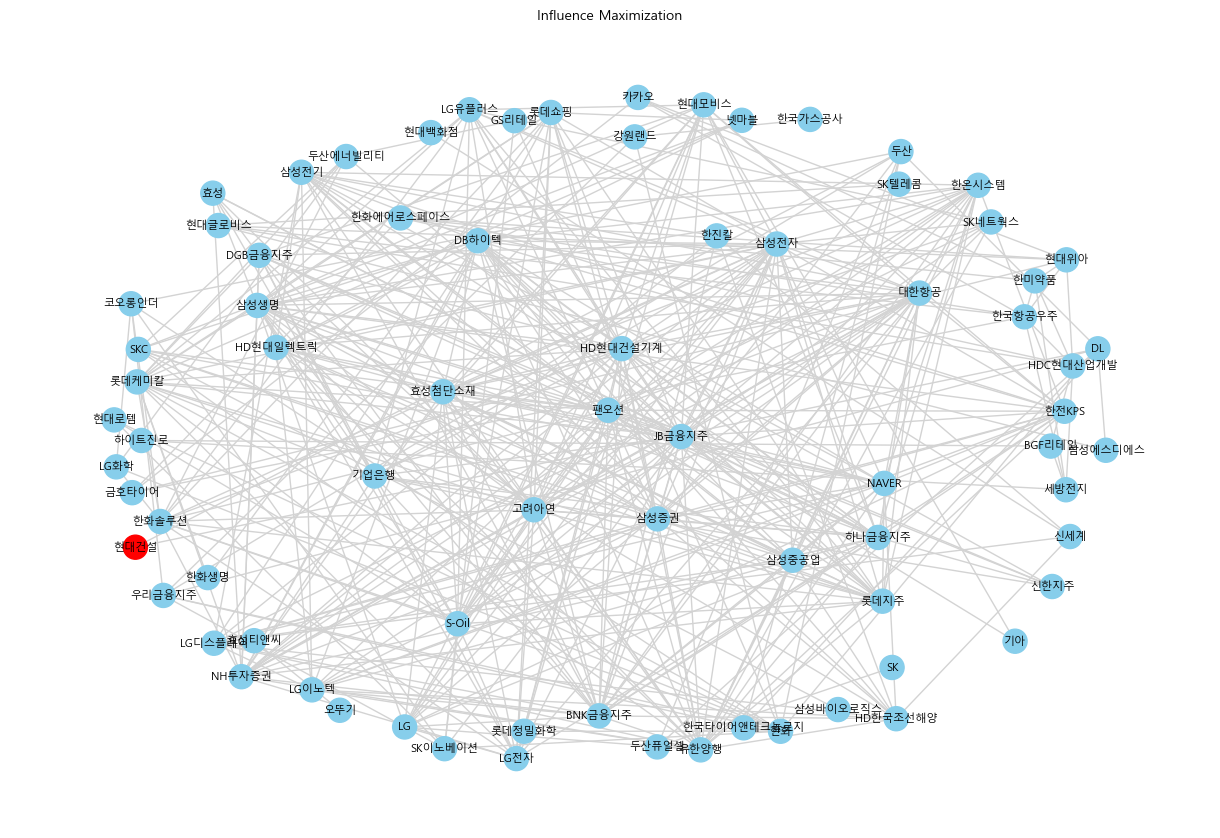

In [24]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 시각화 (선택된 시드 노드를 강조하여 표시)
pos = nx.spring_layout(G, k=2)

node_colors = ['red' if node in seed_nodes else 'skyblue' for node in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='lightgray', node_size=300, font_size=8, font_family=font_prop.get_name())  # 노드 크기 조정
plt.title("Influence Maximization", fontproperties=font_prop)
plt.show()

# Community Detection

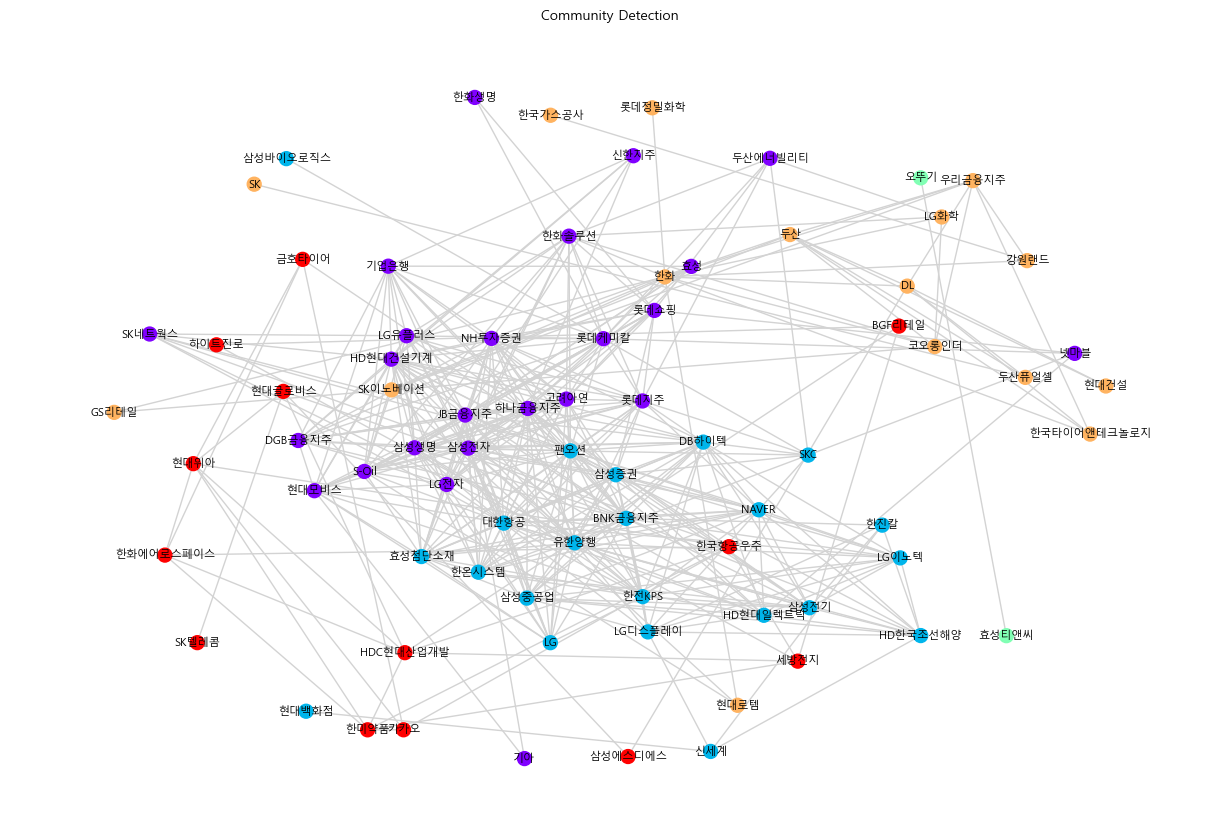

In [25]:
import community as community_louvain

partition = community_louvain.best_partition(G)

# 커뮤니티별로 노드 색상 지정
colors = [partition[node] for node in G.nodes()]

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 그래프 시각화
pos = nx.spring_layout(G, k=1)
plt.figure(figsize=(12, 8))

nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=100, edge_color='lightgray', font_size=8, font_family=font_prop.get_name())
plt.title("Community Detection", fontproperties=font_prop)

plt.show()

In [26]:
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['커뮤니티'])
community_df['종목명'] = community_df.index
community_df.reset_index(drop=True, inplace=True)

# 업종명 추가
community_df = community_df.merge(df[['종목명', '업종명']], on='종목명')

# 커뮤니티와 업종명 카운트 피벗 테이블 생성
pivot_table = community_df.pivot_table(index='커뮤니티', columns='업종명', aggfunc='size', fill_value=0)

# 커뮤니티 이름을 "community 1", "community 2" 형식으로 변경
pivot_table.index = [f"community {i+1}" for i in range(len(pivot_table))]

# 결과 출력
pivot_table

업종명,건설업,기계,기타금융,보험,서비스업,운수장비,운수창고업,유통업,은행,음식료품,의약품,전기가스업,전기전자,증권,철강금속,통신업,화학
community 1,0,2,6,2,1,2,0,2,1,0,0,0,2,1,1,1,3
community 2,1,1,3,0,2,1,3,2,0,0,2,0,6,1,0,0,3
community 3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
community 4,1,0,3,0,1,2,0,1,0,0,0,1,1,0,0,0,9
community 5,1,0,0,0,2,3,2,1,0,1,1,0,1,0,0,1,1
